# Tutorial 
## Tensor product chebychev polynomials for multi-dimensional function aproximation in julia

This library provides a data structure and set of functions to define and use chebychev polynomials to aproximate functions $F:\mathbf{R}^d \rightarrow \mathbf{R}$ defined on rectangual domains $[a,b]\in \mathbf{R}^d $. Currently the library supports interpolations from a regular grid of nodes, defined as the roots of Chebyshev polynomials. The interpolation will provide a chebyshev polynomial that matches the true function values at these nodes and can be used to interpolate inbetween them. Multidimensional function aproximations are supported by the tensor product method decribed in Cai et al 2012. 

In addition to the grid interpolation we hope to support OLS fits in the near future to allow for interpolaiton between irregular grid points. These can also be used to create interpolations when the true value of the function at the grid point is give with some noise as may be the case when it is evaluated with MC integrations. 

The library is based around a data structure call `interpolaiton` a mutable type that stores all of the data required to interpolate a function and evaluate the interpolation at a set of points. This data structure is paired with a set of methods that can be used to initalize and instance `init_interpolation`, update the value at each of the grid points `update_interpolation`, and evalute the function at another set of poits `evaluate_interpolation`. 

The following blocks of code show how to use each of these methods to reprenest and two dimensional function. 

In [16]:
include("tensor_product_chebyshev.jl")
include("OLS_chebyshev.jl")
using Plots

To start we need to define the domain of our function and the number of grid nodes we want to use. each dimension will be assigned the same number of nodes and they will be spaced to match the zeros of chebyshev polynomials.

The domain is defined by specifying a vecotor a with the lower bounds in each dimension and $a$ vector $b$ with the uppe bounds. The number of nodes is given by an integer value $m$. Here we define a function one the square between zero and one with five nodes in each dimension. 

In [7]:
a = [0.0,0.0]
b = [1.0,5.0]
m = 20

20

Once we have defined these parameters we can call the `init_interpolation` method to create our interpolaiton object

In [8]:
itp = TP_chebyshev.init_interpolation(a,b,m)

Main.TP_chebyshev.interpolation(2, [0.0, 0.0], [1.0, 5.0], 20, [0.001541333133436018 0.00770666566718009; 0.013815039801161721 0.06907519900580861; … ; 0.9861849601988383 4.930924800994191; 0.998458666866564 4.99229333433282], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0)  …  (0, 17), (1, 17), (2, 17), (3, 17), (0, 18), (1, 18), (2, 18), (0, 19), (1, 19), (0, 20)])

The `init_interpolation` defines the location for each of the grid points. These locations are assocaited with the roots of chebyshev polynomials.  

The full grid is not stored by `interpolation`. Instead `interpolation.nodes` stores a $m\times d$ matrix that stores the locations of the grid points in each dimension. The `Iterators.product` can be used to reconstruct the full array of grid points if needed.

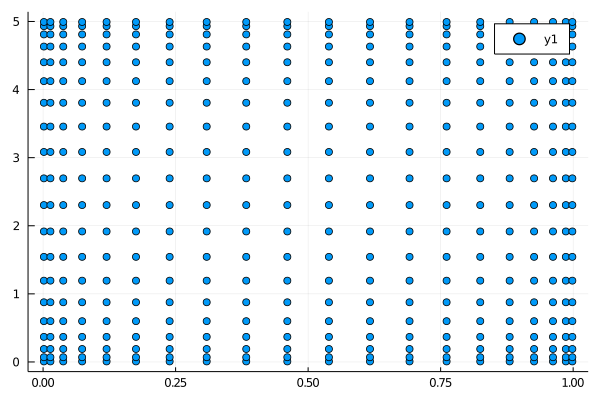

In [9]:
grid = collect(Iterators.product(itp.nodes[:,1],itp.nodes[:,2]))
Plots.scatter(reshape(grid, length(grid)))

The `update_interpolation` method is used to assign the value of the function at each grid point. For example if we want to crete an interpolation of the function $g(x,y) = yx^2-sin\left(5y(x-1)\right)$ we would calculate the value of $g(x,y)$ at each of the nodes. 

In [10]:
g(x) = x[2]*x[1]^2 -sin(5*(x[1]-0.5)*x[2])
v = g.(grid)
itp = TP_chebyshev.update_interpolation(itp,v)

LoadError: [91mcannot define function g; it already has a value[39m

Now that we have updated the value of the interpolation we can use the `evaluate_interpolation` method to retrieve the value of $g(x,y)$ any where in the domain given by $a$ and $b$.

Below I have plotted the true and interpolated values of $g(x,y)$ and the differnce between the two. 

In [11]:
# define grid for plots
x = 0:0.01:1
y = 0:0.01:5
xy = collect(Iterators.product(x,y))

# calculate true values
v_true = g.(xy)


# reshape xy from an array to a vector and call  evaluate_interpolation
vec_xy = reshape(xy,length(xy))
v_itp = TP_chebyshev.evaluate_interpolation(vec_xy,itp)

# convert back to grid for plot
v_itp_grid = reshape(v_itp, length(x), length(y))

# make plots
p1 = Plots.heatmap(y,x,v_true)
p2 = Plots.heatmap(y,x,v_itp_grid)
p3 = Plots.heatmap(y,x,v_itp_grid .- v_true)
plot(p1,p2,p3,layout = 3)


LoadError: [91mMethodError: no method matching -(::Tuple{Float64,Float64}, ::Float64)[39m
[91m[0mClosest candidates are:[39m
[91m[0m  -([91m::Complex{Bool}[39m, ::Real) at complex.jl:307[39m
[91m[0m  -([91m::Missing[39m, ::Number) at missing.jl:115[39m
[91m[0m  -([91m::Float64[39m, ::Float64) at float.jl:403[39m
[91m[0m  ...[39m

### OLS fitting

Many complex numerical analysis problems can be solve most effectively using MNonte Carlo methods. These methods often involve sampling the value of a funcion imperfectly, with some random variation around the true value, away froma regualr grid. Polynomial aproximations can still be useful in these cases but rather than fitting the function exactly to a set of grid points will wnat to use least squares or a similar statistical aproach to fit the function aproximation to our data. The `OLS_chebyshev` module provides a set of methods required to do this. 

The structure of `OLS_chebyshev` mirrors `TP_chebyshev` with the basic data structure `polynomial` and assocaited methods `init_polynomial`, `update_polynomial` and `evaluate_polynomial`. The only substantial differnce is `update_polynomial` takes a vector of values $y = f(x)$ and a matrix of $x$ values and used OLS to fit the polynomials defined in `polynomial` to the data. A brief example is given below. 

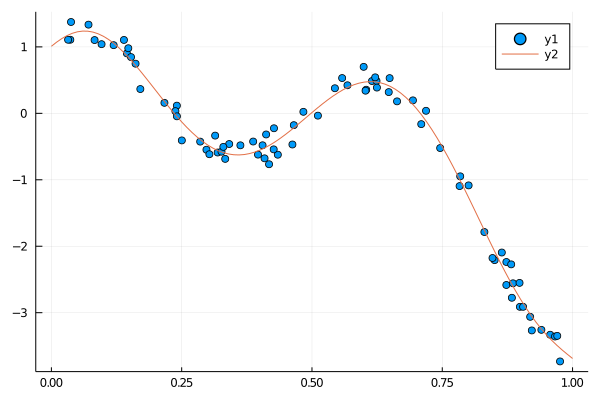

In [35]:
# initialize a polynomial in one dimension of degree 7
include("OLS_chebyshev.jl")
poly = OLS_chebyshev.init_polynomial([0.0],[1.0],7,true)

# define a function to aproximante
g = x ->sin(10*(x-0.5))- 5 *x^2 +2*x

# simulate some data 
x = hcat(rand(80))
y = broadcast(g,x ).+ 0.5.*rand(80)

# update polynomial to match OLS fit to x and y
poly = OLS_chebyshev.update_polynomial!(poly,y,x)

# plot data points 
p1 = Plots.scatter(x,y)
X = 0:0.01:1
x = []
for x_ in X push!(x,[x_]) end
# use evaluate polynomial to plot aproximation
y = OLS_chebyshev.evaluate_polynomial(x,poly)
X = x
x = []
for x_ in X push!(x,x_[1]) end
Plots.plot!(x, y)

In [48]:
X = 0:0.001:1
x = []
for x_ in X push!(x,[x_]) end
@time OLS_chebyshev.evaluate_polynomial(x,poly)


  0.004748 seconds (55.05 k allocations: 2.498 MiB)


1001-element Array{Float64,1}:
  1.009250638718032
  1.0157008532359313
  1.022095067664288
  1.0284308858057778
  1.034705962947566
  1.0409180053902403
  1.0470647699789886
  1.0531440636369709
  1.0591537429009288
  1.0650917134589921
  1.0709559296906925
  1.0767443942091868
  1.0824551574056718
  ⋮
 -3.6197654951659195
 -3.6261439744542674
 -3.632499935915229
 -3.6388357324653056
 -3.645153767832529
 -3.651456497025566
 -3.657746426805041
 -3.6640261161571
 -3.6702981767692004
 -3.676565273508142
 -3.682830124900335
 -3.689095503614324